# HarvestStat Data Profiling - Mali

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32629' # Mali
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/ML_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
parameters = {
    'format': 'json',
    'country': 'Mali',
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1980	 | ML1980A1 | 8	| nan	| 0	| nan	| 0	|
| 1993	 | ML1993A1 | 9	| ML1993A2	| 50	| nan	| 0	|
| 2001	 | ML2001A1 | 9	| ML2001A2	| 50	| nan	| 0	|
| 2016	 | ML2016A1 | 11	| nan	| 0	| nan	| 0	|
----------------------------------------------- #


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# 2. Manual setting
# a) Add admin names to reporting units
admin_level = 'admin_1'
reporting_unit = df.loc[df['fnid'].map(lambda x: x[6] != 'A'), 'fnid'].unique()
df.loc[df.fnid.isin(reporting_unit),admin_level] = df.loc[df.fnid.isin(reporting_unit), 'locality_name'].map(lambda x: x.split(' ')[0])
# Remove "Millet and sorghum mix" from crop list. This type only covers from 1974 to 1981.
df = df.loc[~df['product'].str.contains('Millet and sorghum mix'),:].reset_index(drop=True)
# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority='Area Planted')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([ML_Admin1_1980, ML_Admin1_1993, ML_Admin1_2001, ML_Admin1_2016], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 12,696
Removed 5,807 "Missing Value" points
0/3,174 "Area Harvested" points are retained.
2,321/3,174 "Area Planted" points are retained.
2,330/3,174 "Quantity Produced" points are retained.
2,238/3,174 "Yield" points are retained.
Current data points: 6,889

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1974 - 2022
19 grain types are found: Bambara groundnut, Barley (Unspecified), Beans (mixed), Cassava, Cotton (Unspecified), Cowpea (unspecified), Fonio, Groundnuts (In Shell), Maize (Corn), Millet, Rice (Paddy), Sesame Seed, Sorghum, Soybean (unspecified), Sugarcane (for sugar), Sweet Potatoes, Tomato, Wheat Grain, Yams
1 seasons are found: Main (05-01)
1 crop production system are found: All (PS)
Data sources include:
[1] Direction Nationale de l'Agriculture/Direction Nationale de la Statistique et de l'Informatique, Mali --- Annuaire Statistique

- Mali crop seasonal calendar

<img src="https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-mali.png?itok=KHYcSEwF" width=900>

- FDW data consists of `ML1980A1`, `ML1993A1`, and `ML2016A1`.

| Year | Admin-1 | # units  | Admin-2  | # units |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1980  | **`ML1980A1`** | 8        | - | -      |
| 1993  | **`ML1993A1`** | 9  | ML1993A2 | 50      |
| 2001  | ML2001A1 | 9  | ML2001A2 | 50     |
| 2016  | **`ML2016A1`**| 11  | - | -      |

- Comparison between admin boundaries.

<img src="https://github.com/chc-ucsb/gscd/blob/main/figures/ML_admin_shapes.png?raw=true" width=900>

- In 1993, 1 district is divided and added.

| 1980-1992 |1993-2001|
| :---:|:---:|
|ML1980A110 (Gao) | ML1993A107 (Gao), ML1993A108 (Kidal)|

- In 2001, the boundary has been slightly changed with no major split or aggregation.

- In 2016, 2 district is divided and added.

| 2001-2015 |2016-present|
| :---:|:---:|
|ML2001A107 (Gao) | ML2016A107 (Gao), ML2016A110 (Menaka)|
|ML1993A106 (Tombouctou) | ML2016A106 (Tombouctou), ML2016A111 (Taoudenit)|

- **`ML2016A1`** is used to represent current admin-level 1 crop data.
- Mali has a single crop season: `Main`.
- Mali has no population group(s).

In [4]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = ML_Admin1_2016.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

ML2001A104:	"Segou" (FDW) is changed to "Ségou" (shapefile).


In [5]:
# Link admin boundaries ------------------------- #
link_1980, over_1980 = FDW_PD_CreateAdminLink(ML_Admin1_1980, ML_Admin1_2016, 'ADMIN1', 'ADMIN1', prod, epsg)
link_1980['ML1980A109'].update(method='PBR')
link_1980['ML1980A102'].update(method='PBR')
link_1980['ML1980A110'].update(method='PBR')
link_1980['ML1980A106'].update(method='PBR')
assert all(np.unique([v['method'] for k,v in link_1980.items()]) == 'PBR')
link_1993, over_1993 = FDW_PD_CreateAdminLink(ML_Admin1_1993, ML_Admin1_2016, 'ADMIN1', 'ADMIN1', prod, epsg)
link_1993['ML1993A109'].update(method='PBR')
link_1993['ML1993A102'].update(method='PBR')
link_1993['ML1993A106'].update(method='PBR')
link_1993['ML1993A107'].update(method='PBR')
link_1993['ML1993A108'].update(method='PBR')
assert all(np.unique([v['method'] for k,v in link_1993.items()]) == 'PBR')
link_2001, over_2001 = FDW_PD_CreateAdminLink(ML_Admin1_2001, ML_Admin1_2016, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2001['ML2001A106'].update(method='PBR')
link_2001['ML2001A107'].update(method='PBR')
assert all(np.unique([v['method'] for k,v in link_2001.items()]) == 'PBR')
# Crop specific ratios
link_ratio_1980 = FDW_PD_RatioAdminLink(link_1980, prod, over_1980, mdx_pss)
link_ratio_1993 = FDW_PD_RatioAdminLink(link_1993, prod, over_1993, mdx_pss)
link_ratio_2001 = FDW_PD_RatioAdminLink(link_2001, prod, over_2001, mdx_pss)
# Merge link_ratio
assert link_ratio_1980.keys() == link_ratio_1993.keys() == link_ratio_2001.keys()
link_merged = [link_ratio_1980, link_ratio_1993, link_ratio_2001]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=True)
# ----------------------------------------------- #

CBR is considered for 'ML1980A110' as no record found in: ['ML2016A110']
CBR is considered for 'ML1980A106' as no record found in: ['ML2016A111']
CBR is considered for 'ML1993A107' as no record found in: ['ML2016A110']
CBR is considered for 'ML1993A106' as no record found in: ['ML2016A111']
CBR is considered for 'ML2001A106' as no record found in: ['ML2016A111']
CBR is considered for 'ML2001A107' as no record found in: ['ML2016A110']


In [6]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Manual change of product name
product_category_custom = {
    'Bambara groundnut': 'Bambara groundnut',
    'Barley (Unspecified)': 'Barley',
    'Beans (mixed)': 'Beans (mixed)',
    'Cotton (Unspecified)': 'Cotton',
    'Cowpea (unspecified)': 'Cowpeas',
    'Fonio': 'Fonio',
    'Groundnuts (In Shell)': 'Groundnuts (In Shell)',
    'Maize (Corn)': 'Maize',
    'Millet': 'Millet',
    'Rice (Paddy)': 'Rice',
    'Sesame Seed': 'Sesame Seed',
    'Sorghum': 'Sorghum',
    'Soybean (unspecified)': 'Soybean',
    'Sugarcane (for sugar)': 'Sugarcane',
    'Sweet Potatoes': 'Sweet Potatoes',
    'Tomato': 'Tomato',
    'Wheat Grain': 'Wheat',
    'Yams': 'Yams'
}
assert set(stack['product'].unique()) == set(product_category_custom.keys())
stack['product'] = stack['product'].replace(product_category_custom)
for f, r in link_ratio.items():
    mdx = pd.MultiIndex.from_frame(r.index.to_frame().reset_index(drop=True).replace(product_category_custom))
    r.index = mdx
    link_ratio[f] = r
# Calibration of crop calendar using External Crop Calendar (ECC)
ecc = pd.read_csv('../data/crop_calendar/external_crop_calendar.csv')
ecc = ecc[ecc['country'] == 'Mali']
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, ecc, link_ratio)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

# Save data
fn_out = '../data/crop/adm_crop_production_ML.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')
save_npz('../data/crop/adm_crop_production_ML_ratio.npz', link_ratio)

All [season_name, product, crop_production_system] are in the external crop calendar.
../data/crop/adm_crop_production_ML.csv is saved.
../data/crop/adm_crop_production_ML_ratio.npz is saved.


# Visualization of production data

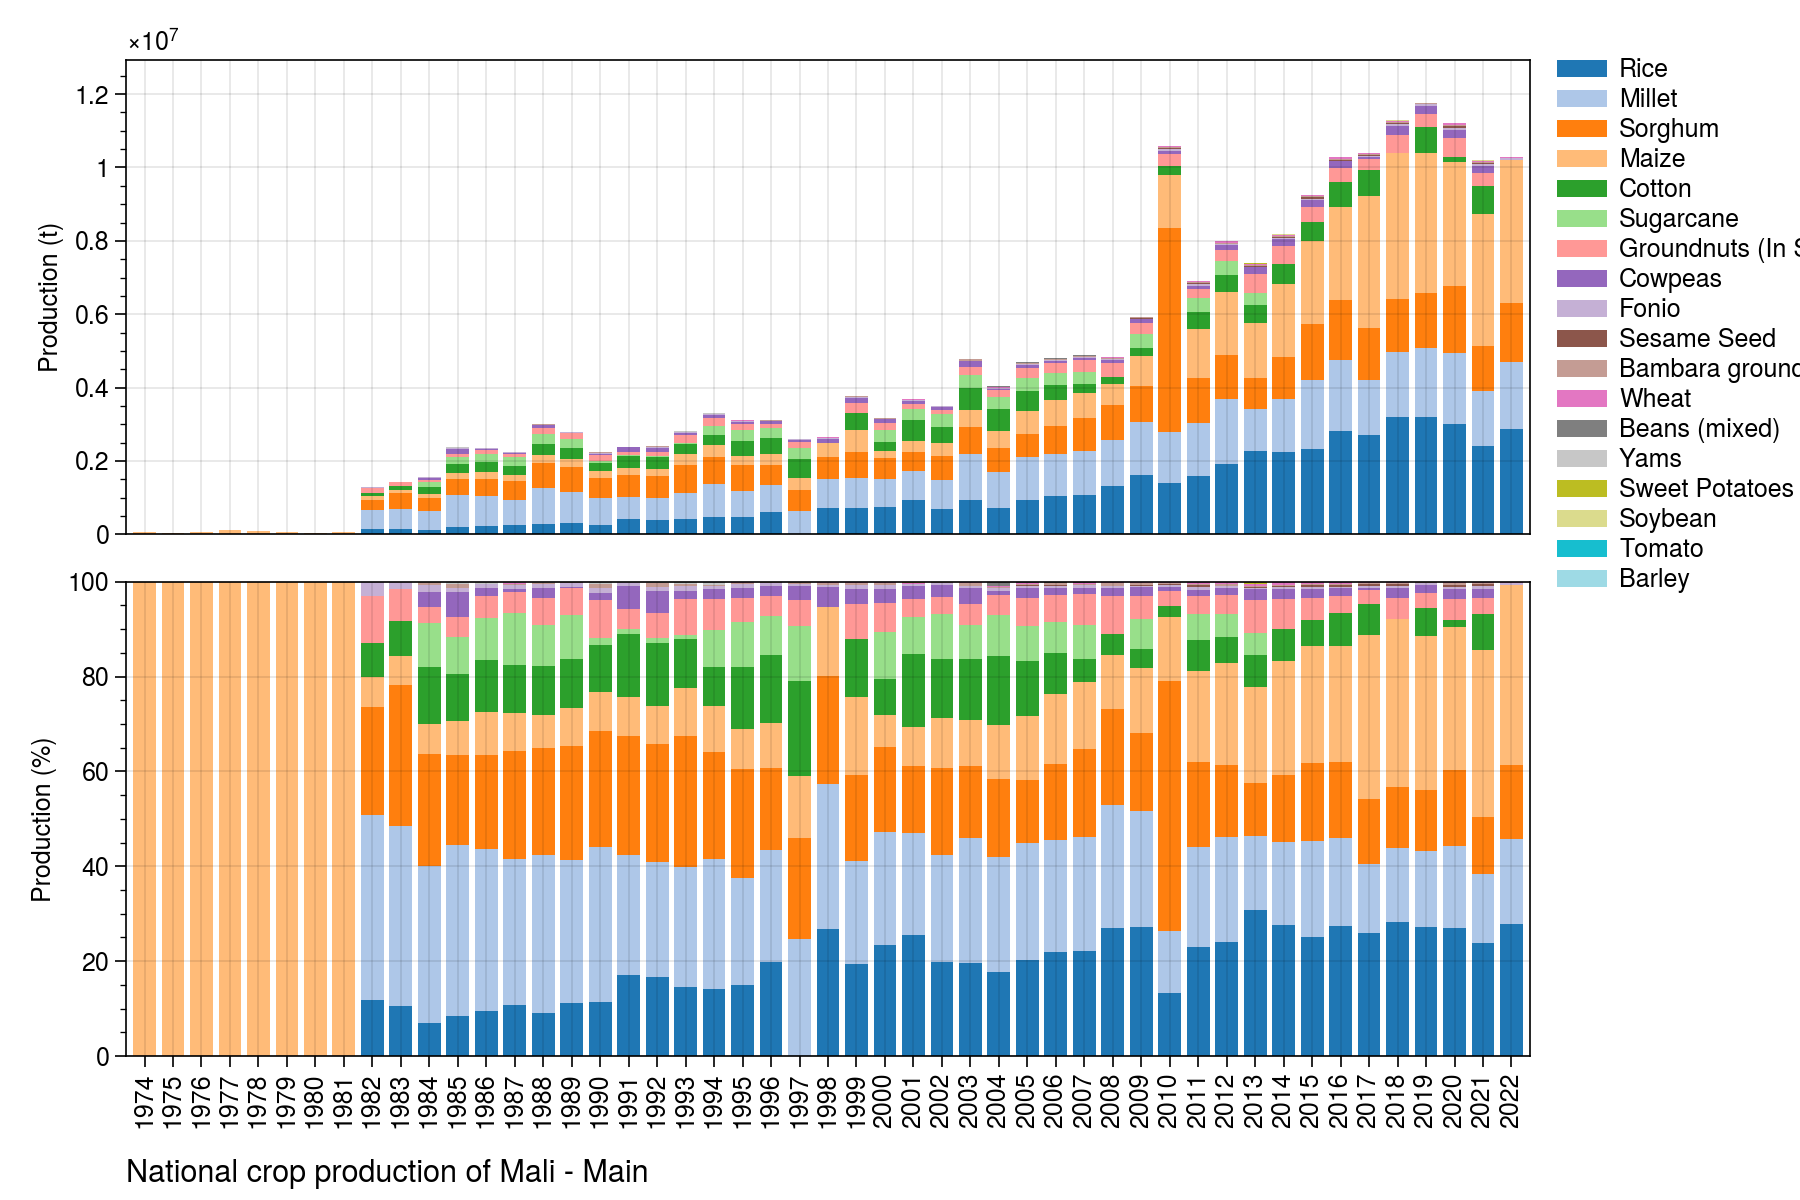

../figures/ML_bar_natgrainprod_Main.png is saved.


In [7]:
# Bar chart of national grain production
country_iso, country_name = 'ML', 'Mali'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_order = ['Maize','Millet','Rice','Sorghum','Wheat','Barley','Fonio']
for season_name in ['Main']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

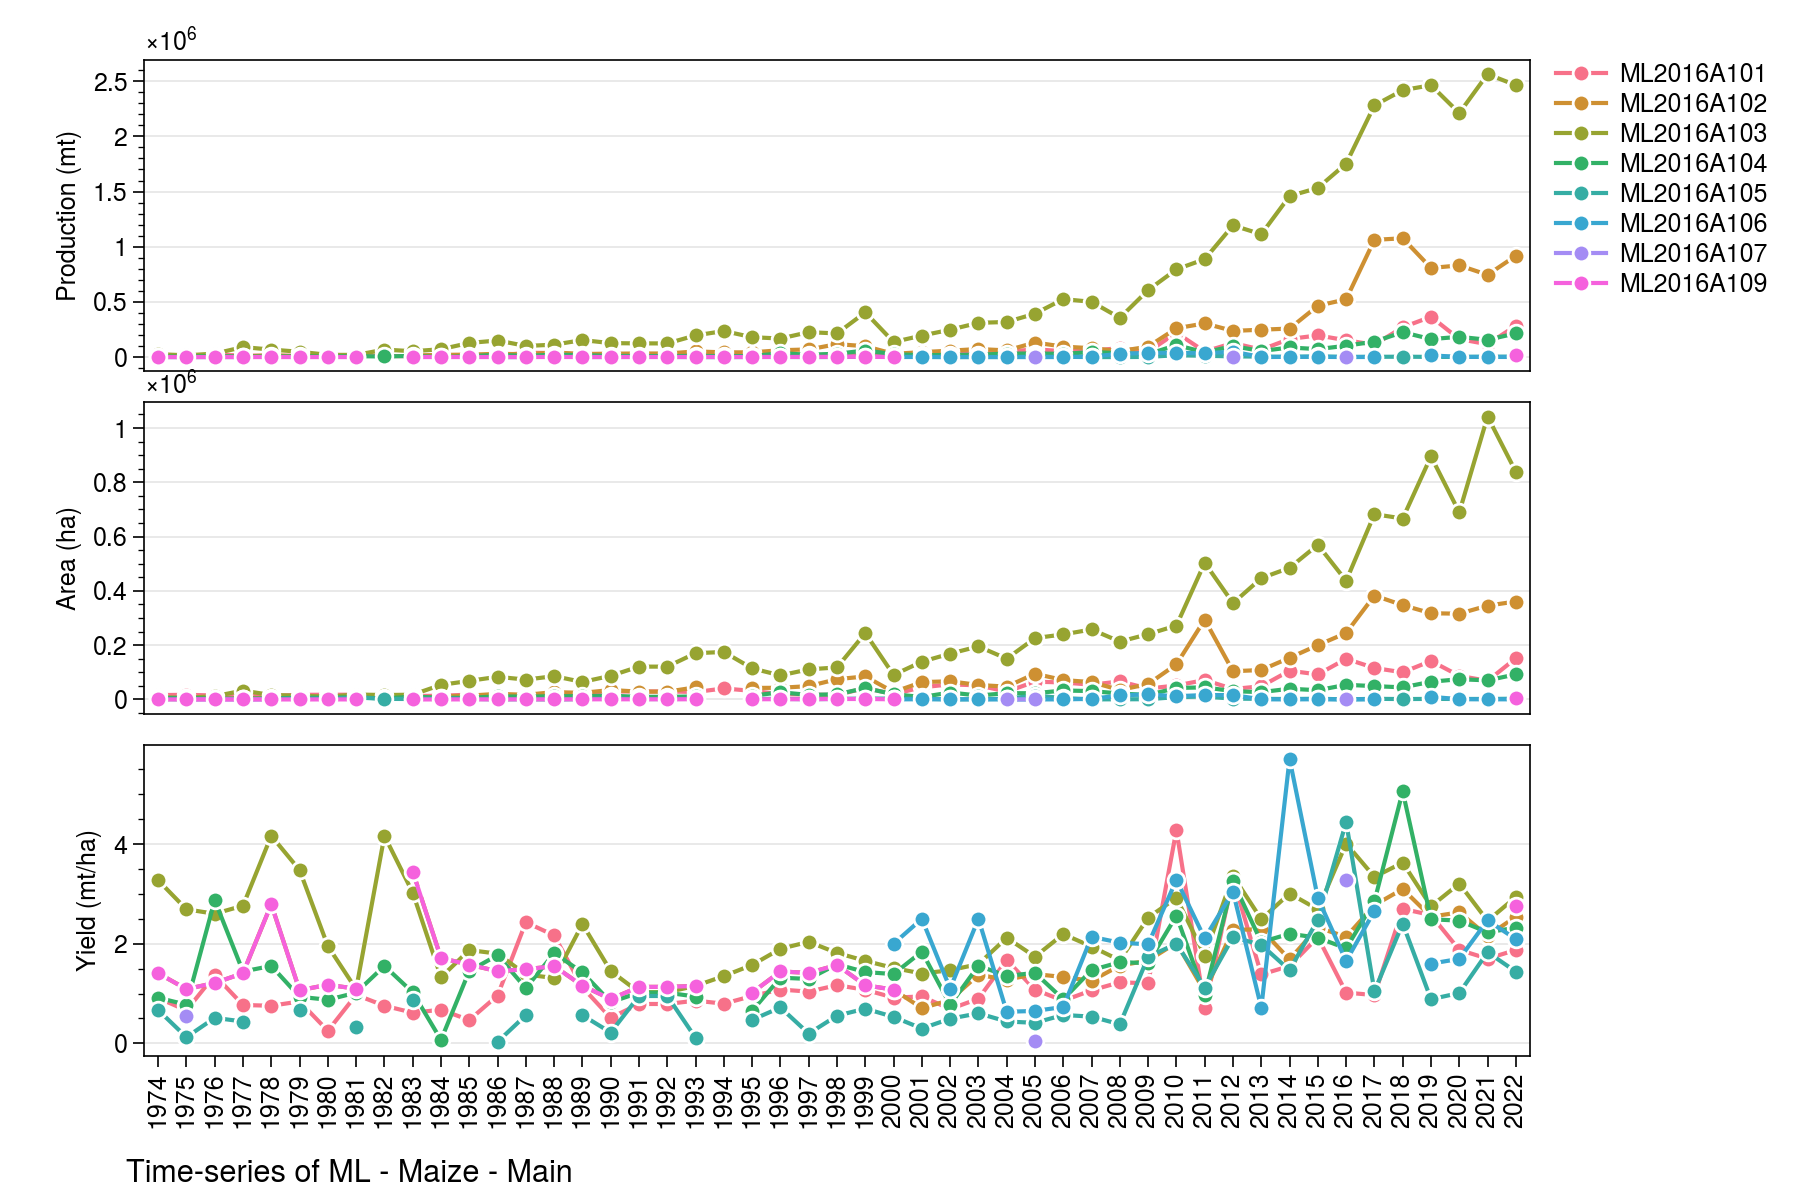

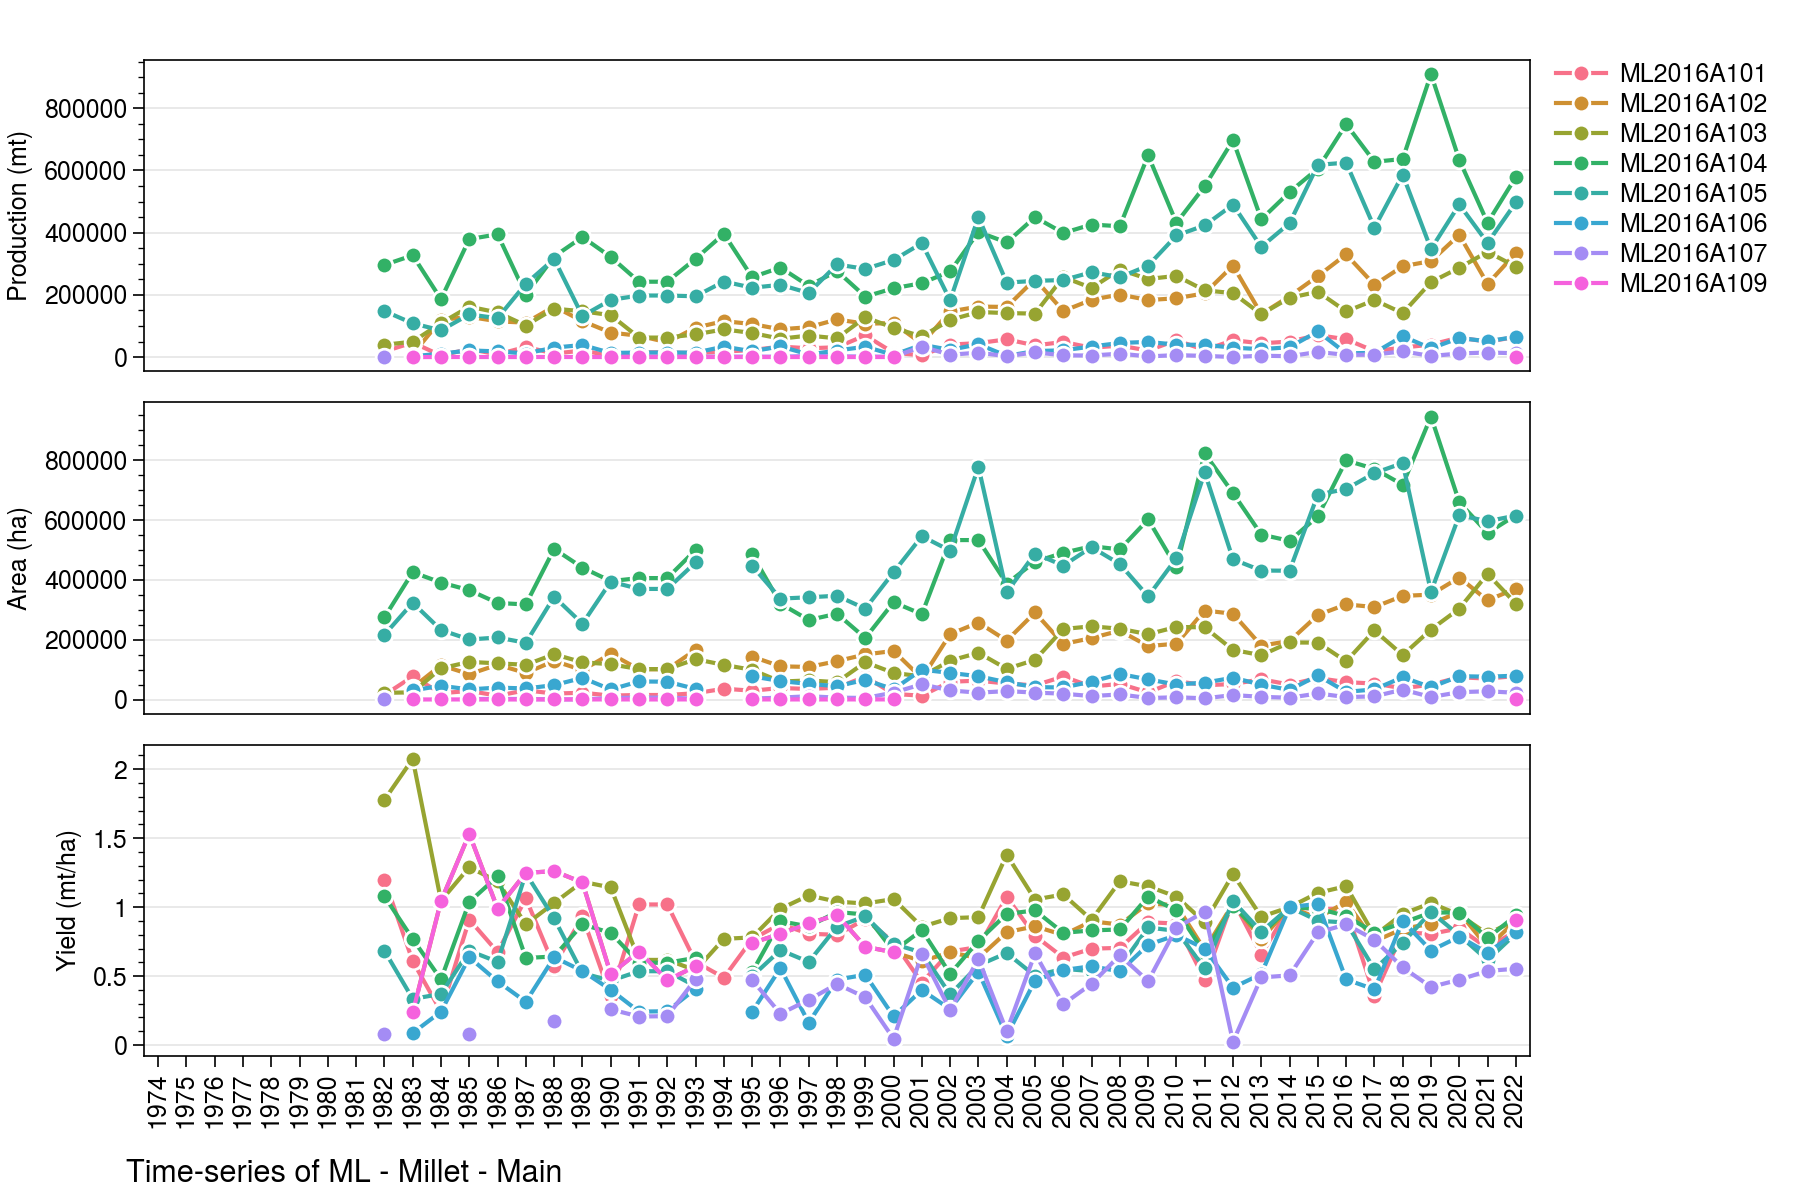

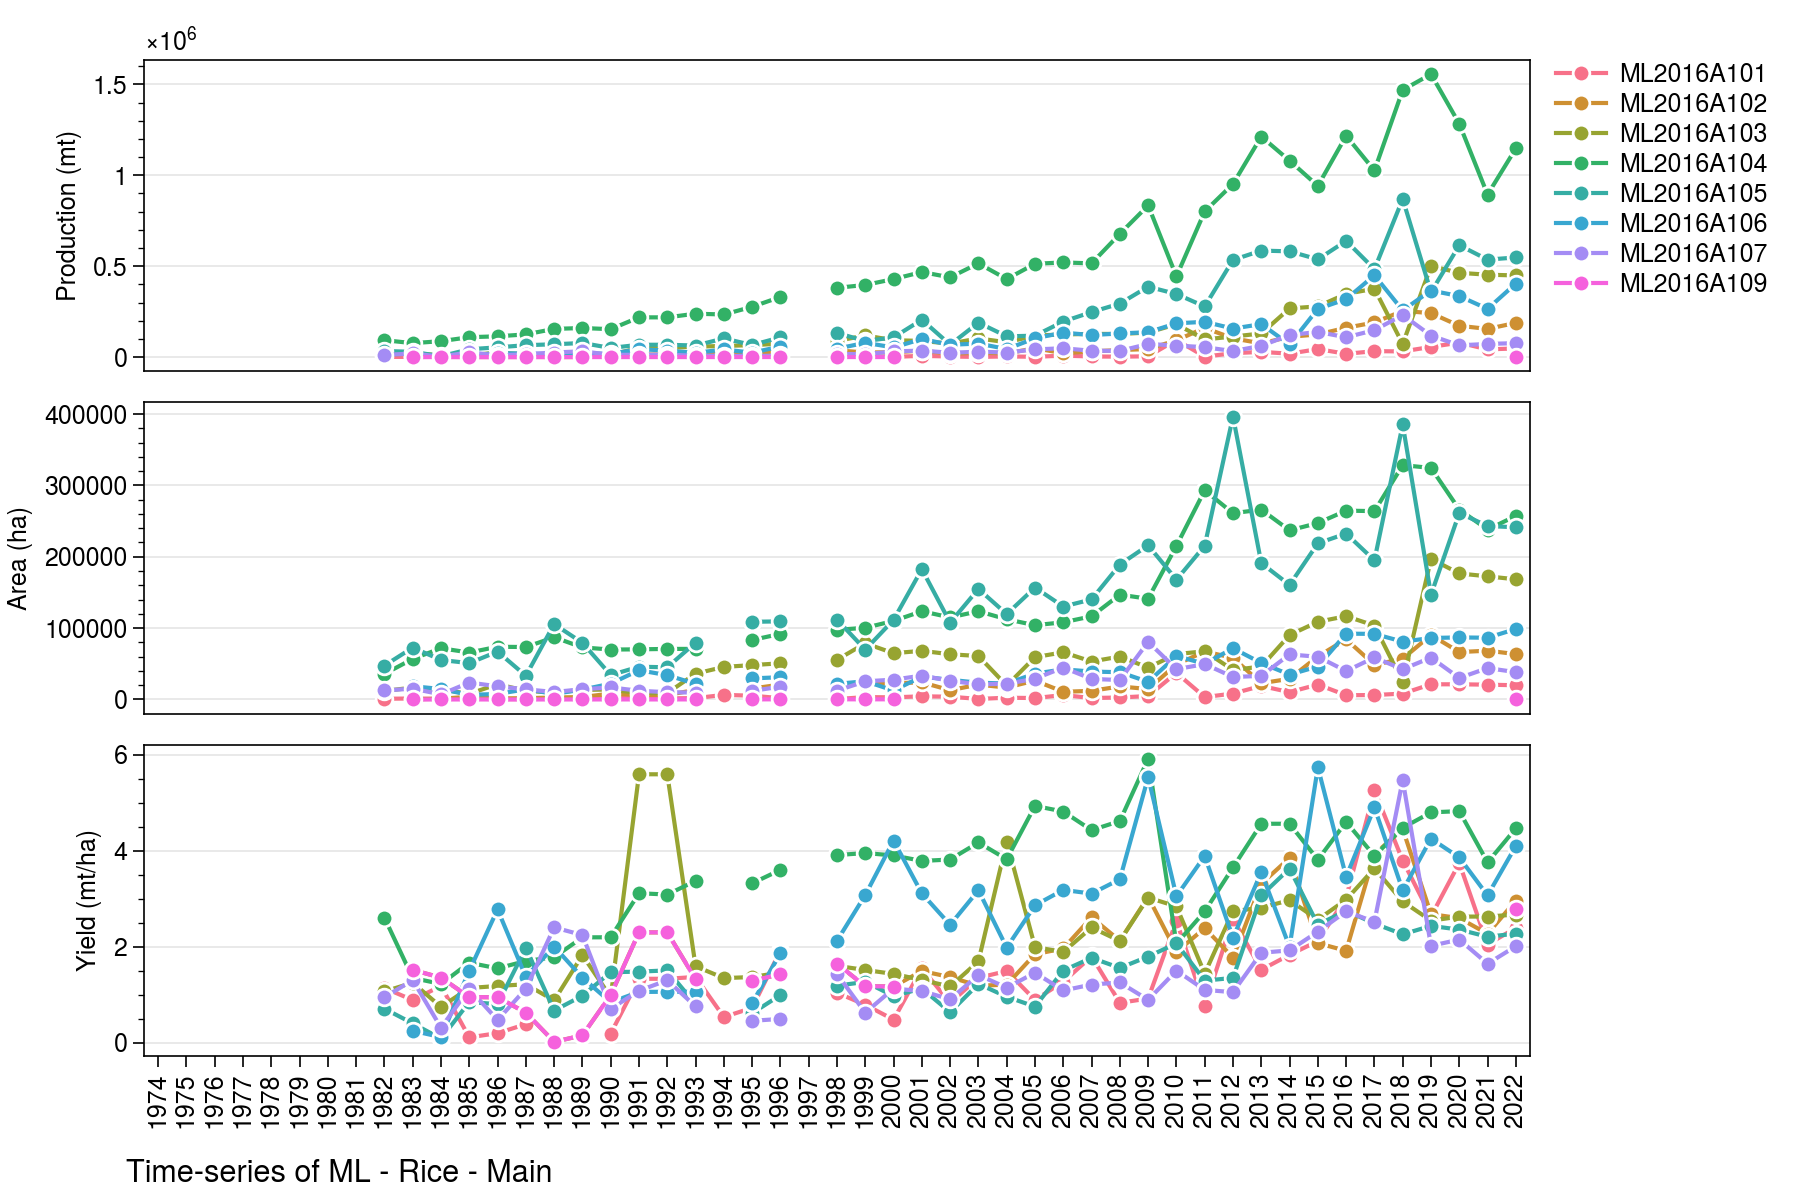

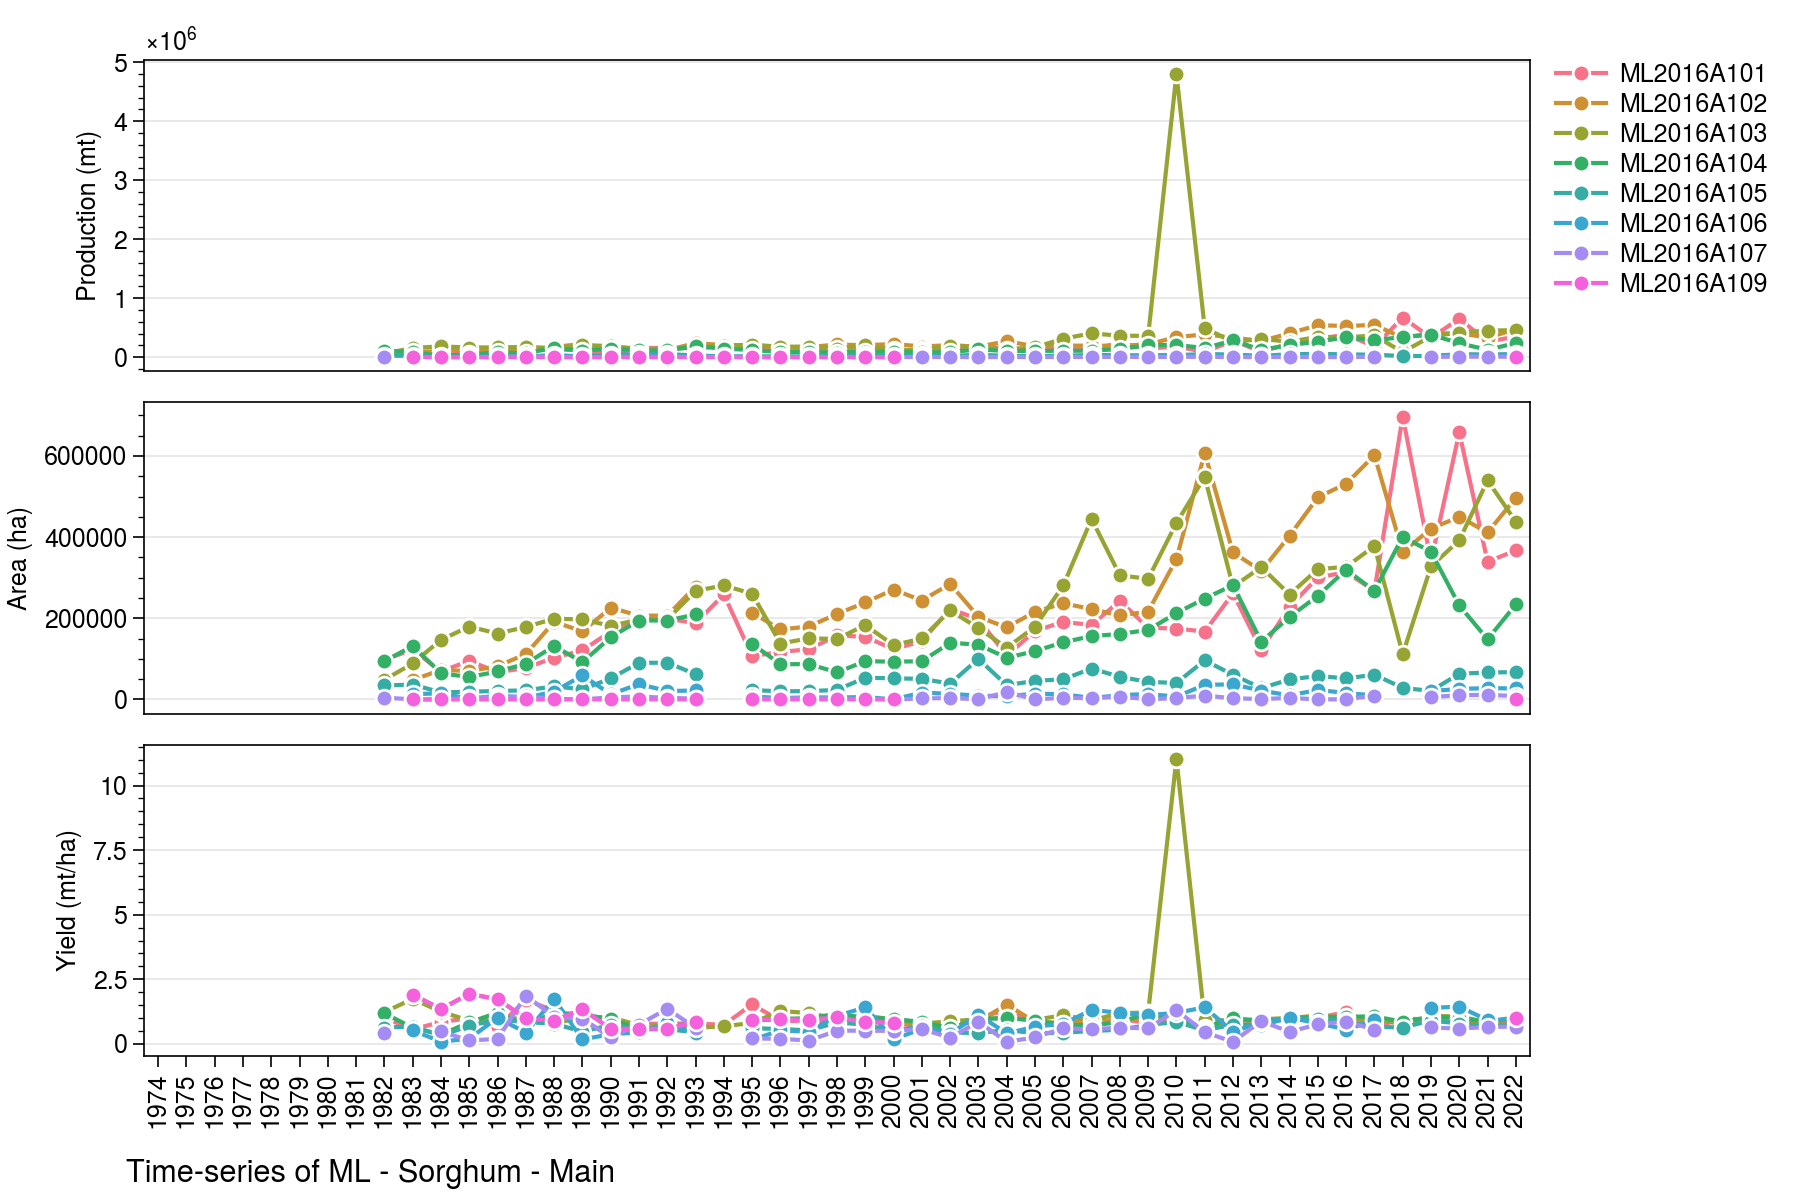

In [8]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'ML', 'Mali'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
product_season = [
    ['Maize','Main'],
    ['Millet','Main'],
    ['Rice','Main'],
    ['Sorghum','Main'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)